# ML4L Workflow

The `ML4L` project is trying to use ML techniques to learn the land surface temperature (LST). 

This notebook attempts to track each stage of the project, from the raw data to the output plots, to enable reproducible research.

The only inputs a user needs to recreate this work is the raw data from ECMWF.

---
# Table of contents
1. [Raw Data](#rawdata) <br>

    1.1 [ERA5 data](#rawdataERA5) <br>
...1.1.1 [Processing ERA5 data](#rawdataERA5processing) <br>
    1.2 [MODIS data](#rawdataMODIS) <br>
    1.3 [Data Overview](#rawdataOverview) <br>
    
2. [Joining data](#joiningdata) <br>
3. [Training a Model](#trainingmodel) <br>
4. [Analysis and Visualisation](#analysis) <br>

---

# 1. Raw Data <a name="rawdata"></a>
Any ML project needs data.

We can split this into two main categories: inputs and outputs.

Inputs are the features that go into our ML model. Outputs are the things we are trying to learn.

For this project:

* Inputs: ERA5 data

* Outputs: MODIS data

## 1.1 ERA5 Data <a name="rawdataERA5"></a>

We have a few different raw sources of ERA5 data provided by ECMWF

**a)** ERA_sfc. 3 years of data (2018-2020), hourly grain. Features: `sp, msl, 10u, 10v, 2t.` 

In [5]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_sfc/sfc_unstructured_2018_01.grib | head -10

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_sfc/sfc_unstructured_2018_01.grib
edition      centre       typeOfLevel  level        dataDate     stepRange    dataType     shortName    packingType  gridType     
1            ecmf         surface      0            20180101     0            an           sp           grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           msl          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           10u          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           10v          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           2t           grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           sp           grid_

**b)** ERA_skin. 10 years of data (2010-2020), hourly grain. Features: `aluvp,aluvd,alnip ,alnid,cl,cvl,cvh,istl1,istl2,slt,sdfor,z,sd,sdor,isor,anor,slor
2d,lsm,fal`



In [4]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib | head -25

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib
edition      centre       typeOfLevel  level        dataDate     stepRange    dataType     shortName    packingType  gridType     
1            ecmf         surface      0            20180101     0            an           aluvp        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           aluvd        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           alnip        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           alnid        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           cl           grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           cvl         

**c)** ERA_skt. 3 years of data (2018-2020), hourly grain. Features: `skt`

In [14]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skt/skt_unstructured_2018_01.grib | head -5

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skt/skt_unstructured_2018_01.grib
edition      centre       typeOfLevel  level        dataDate     stepRange    dataType     shortName    packingType  gridType     
1            ecmf         surface      0            20180101     0            an           skt          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           skt          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           skt          grid_simple  reduced_gg  


**d)** V15 surface. Some additional constant in time features. Overlaps with some data we already have. Note there also exist `clake` and `lsmoro`, which describe features we have above.

In [11]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/sfc 

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/sfc
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20131129     an           reduced_gg   0            surface      0            anor         grid_simple 
2            ecmf         20131129     an           reduced_gg   0            surface      0            isor         grid_simple 
2            ecmf         20131129     an           reduced_gg   0            surface      0            slor         grid_simple 
2            ecmf         20131129     an           reduced_gg   0            surface      0            sdor         grid_simple 
1            ecmf         19960101     not_found    reduced_gg   0            surface      0            sr           grid_simple 
1            ecmf         19960101     not_found    reduced_gg   0            surface      0            lsrh  

**e)** V20 surface. More up to date (version 20) fields. Overlaps with some data we already have:

In [13]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/clake
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/lsmoro
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/sfc

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/clake
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20110131     af           reduced_gg   0            surface      0            cl           grid_simple 
1 of 1 messages in /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/clake

1 of 1 total messages in 1 files
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/lsmoro
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20210222     an           reduced_gg   0            surface      0            lsm          grid_simple 
2            ecmf         20210222     an           reduced_gg   0            surface      

## 1.1.1 Processing ERA5 Data <a name="rawdataERA5processing"></a>


Given all this data in disparate files, it will be useful to bring it all together in a usable format.

There is some overlap between files, with some files holding the same features.

There is also some degneracy in that we are needlessly holding values of features which are constant in time

**Which data is constant in time?**

In [27]:
import xarray as xr
import numpy as np
import pandas as pd

example_ERA_sfc_file = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_sfc/sfc_unstructured_2018_01.grib'
example_ERA_skin_file = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib'

def check_if_variables_are_constant(ds): 
    """For all the variables in this ds, are they constant in time for each grid point?"""
    
    #Get all variables/features
    all_variables = list(ds.keys())

    names = []
    variations = []
    for v in all_variables:
    
        a = ds[v].values
        #a == a[0,:] compares each value to the corresponding value in the first row
        #A column shares a common value if all the values in that column are True
        is_constant = all(np.all(a == a[0,:], axis = 0))
        
        
        print (v,is_constant)
        names.extend([v])
        variations.extend([is_constant])
        

In [28]:
ds_sfc = xr.open_dataset(example_ERA_sfc_file,engine='cfgrib',backend_kwargs={'indexpath': ''} )
check_if_variables_are_constant(ds_sfc)

#Surface skin values. Filter out istl1,2 else errors.
ds_skin = xr.open_dataset(example_ERA_skin_file,engine='cfgrib',filter_by_keys={'typeOfLevel': 'surface'}, backend_kwargs={'indexpath': ''} ) 
check_if_variables_are_constant(ds_skin)

sp False
msl False
u10 False
v10 False
t2m False
aluvp False
aluvd False
alnip False
alnid False
cl True
cvl True
cvh True
slt True
sdfor True
z True
sd False
sdor True
isor True
anor True
slor True
d2m False
lsm True
fal False


In [34]:
#Now deal with istl1,2 individually
ds_istl1 = xr.open_dataset(example_ERA_skin_file,engine='cfgrib',filter_by_keys={'shortName': 'istl1'}, backend_kwargs={'indexpath': ''} ) 
check_if_variables_are_constant(ds_istl1)

ds_istl2 = xr.open_dataset(example_ERA_skin_file,engine='cfgrib',filter_by_keys={'shortName': 'istl2'}, backend_kwargs={'indexpath': ''} ) 
check_if_variables_are_constant(ds_istl2)


istl1 False
istl2 False


We have just demonstrated a month of data here, but it is straightforward to extend to multiple months and the conclusions are unchanged

---


With the features which are constant in time identified, we need to take the following steps:

For each month: 
* Extract the time variable features from ERA skin: `aluvp,aluvd,alnip,alnid,istl1,istl2,sd,2d,fal`
* Merge the time variable ERA skin, ERA surface and ERA skt into a single file

This is done in `scripts/process_time_variable_data.py`.
    
For one month:
* Extract the constant time features from ERA skin, that are not covered in V15, V20.: `slt,sdfor`
* Bring together with the V15 and V20 data

This is done in `scripts/process_time_constant_data.py`.

The final outputs of ERA data are then

* `ERA_time_variable` * nmonths. GRIB format. `processed_data/ERA_timevariable`
* `ERA_constant_V15` * 1. NetCDF format. `processed_data/ERA_timeconsant`
* `ERA_constant_V20` * 1. NetCDF format. `processed_data/ERA_timeconsant`

The complete list of features is:

In [134]:
feature_names = ['sp', 'msl', 'u10', 'v10', 't2m',
            'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m','fal', 
            'skt', 
            'lsm',  'slt', 'sdfor','lsrh', 'cvh',  'z', 'isor', 'sdor', 'cvl','cl','anor', 'slor', 'sr', 'tvh', 'tvl']

import requests
import pandas as pd

r = requests.get("https://apps.ecmwf.int/codes/grib/json/").json()['parameters']

def param_name(x,r):
    try:
        d = next(item for item in r if item["param_shortName"] == x)
        name = d['param_name']
        units = d['units_name']
    except:
        #maybe naming convention is different
        name = 'Null'
        units = 'Null'
    
    return f'{x}: {name} : {units}'


for i in feature_names:
    print(param_name(i,r))

sp: Wind speed (SP) : m s**-1
msl: Mean sea level pressure : Pa
u10: Null : Null
v10: Null : Null
t2m: Null : Null
aluvp: UV visible albedo for direct radiation : (0 - 1)
aluvd: UV visible albedo for diffuse radiation : (0 - 1)
alnip: Near IR albedo for direct radiation : (0 - 1)
alnid: Near IR albedo for diffuse radiation : (0 - 1)
istl1: Ice temperature layer 1 : K
istl2: Ice temperature layer 2 : K
sd: Snow depth water equivalent : kg m**-2
d2m: Null : Null
fal: Forecast albedo : (0 - 1)
skt: Skin temperature : K
lsm: Land-sea mask : (0 - 1)
slt: Soil type : ~
sdfor: Standard deviation of filtered subgrid orography : m
lsrh: Logarithm of surface roughness length for heat : ~
cvh: High vegetation cover : (0 - 1)
z: Geopotential : m**2 s**-2
isor: Anisotropy of sub-gridscale orography : ~
sdor: Standard deviation of orography : m
cvl: Low vegetation cover : (0 - 1)
cl: Lake cover : (0 - 1)
anor: Angle of sub-gridscale orography : radians
slor: Slope of sub-gridscale orography : ~
sr: 

Note there could be some errors in these definitions. For instance, `sp` is surface pressure according to [ECMMWF param database](https://apps.ecmwf.int/codes/grib/param-db/), but the json request returns it as wind speed...? Nulls occur when the feature names we are using don't match with those in database.

## 1.2 MODIS Data <a name="rawdataMODIS"></a>

The MODIS data requires less (or rather no!) processing than the ERA5 data.

Daily `.tiff` files are found at `/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/` and are easy to load and process


## 1.3 Data Overview <a name="rawdataOverview"></a>

It is useful for the intution to have a quick look at each of our data sources: 

* ERA5 time variable:

In [46]:
f = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_0.grib'
ERA5_timevariable = xr.open_dataset(f,engine='cfgrib',backend_kwargs={'indexpath': ''} )
display(ERA5_timevariable)

<xarray.Dataset>
Dimensions:              (time: 744, values: 542080)
Coordinates:
    number               int64 ...
  * time                 (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:0...
    step                 timedelta64[ns] ...
    surface              float64 ...
    latitude             (values) float64 ...
    longitude            (values) float64 ...
    valid_time           (time) datetime64[ns] ...
    depthBelowLandLayer  float64 ...
Dimensions without coordinates: values
Data variables: (12/15)
    sp                   (time, values) float32 ...
    msl                  (time, values) float32 ...
    u10                  (time, values) float32 ...
    v10                  (time, values) float32 ...
    t2m                  (time, values) float32 ...
    aluvp                (time, values) float32 ...
    ...                   ...
    istl1                (time, values) float32 ...
    istl2                (time, values) float32 ...
    sd                   (time, values) float32 ...
    d2m                  (time, values) float32 ...
    fal                  (time, values) float32 ...
    skt                  (time, values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-04-10T15:29 GRIB to CDM+CF via cfgrib-0.9.1...

* ERA5 time constant, v15 and v20:

In [47]:
f = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timeconstant/ERA_constants_v15.nc'
ERA5_timevariable = xr.open_dataset(f)
display(ERA5_timevariable)

<xarray.Dataset>
Dimensions:     (time: 1, values: 542080)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2018-01-01
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (values) float64 ...
    longitude   (values) float64 ...
    valid_time  (time) datetime64[ns] ...
Dimensions without coordinates: values
Data variables: (12/15)
    slt         (time, values) float32 ...
    sdfor       (time, values) float32 ...
    lsrh        (values) float32 ...
    cvh         (values) float32 ...
    lsm         (values) float32 ...
    z           (values) float32 ...
    ...          ...
    cl          (values) float32 ...
    anor        (values) float32 ...
    slor        (values) float32 ...
    sr          (values) float32 ...
    tvh         (values) float32 ...
    tvl         (values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-04-10T13:00 GRIB to CDM+CF via cfgrib-0.9.1...

* MODIS

In [48]:
f = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/aquaDay_errorGTE03K_04km_2018-01-01.tif'
MODIS_data = xr.open_dataarray(f,engine="rasterio")
display(MODIS_data)

<xarray.DataArray 'band_data' (band: 1, y: 5400, x: 10800)>
[58320000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 180.0 180.0
  * y            (y) float64 89.98 89.95 89.92 89.88 ... -89.92 -89.95 -89.98
    spatial_ref  int64 ...
Attributes:
    long_name:  LST_Day_1km

---
# 2. Joining Data <a name="joiningdata"></a>


We have our inputs `ERA` and our outputs `MODIS` in a nice clean form.

We now need to join these two data sources in both space and time.

What this means is, for a bunch of ERA features at time `t` and grid point `x` what is the corresponding real-world observation provided by MODIS?

This is implemented in `scripts/join_MODIS_with_ERA.py`

The general method is as follows:

* Load a day of MODIS data

* Apply latitude bounds (|lat| < 70), calculate the 'absolute' UTC from the longitude and filter this data to an hour. 

* Load a month of ERA data

* Filter this data to an hour. Apply lsm > 0.5. 

* Use `faiss_knn()` to join ERA_hour + MODIS_hour in space. `faiss_knn()` implements a GPU accelerated k nearest neighbours algo. See https://github.com/facebookresearch/faiss . 
    * For each MODIS data point, find the nearest ERA grid point, where nearness is an L2 (squared) norm on the lat/long coordinates.
    * Filter out those matches where the Haversine distance is > 50 km
    * We now have multiple MODIS data points for each ERA grid point. Groupby and take an average


Monthly joined data is written to `processed_data/joined_data`.

Also note:

* Matching 1 month of data takes ~17 mins for one version. For two versions, ~30mins - i.e. sub linear scaling. There may be a more efficient way to do this - for now we will settle with this as "good enough", as the matching only needs to be done once. In practice, matching 3 years of data, both versions takes ~12-14 hours.

* During the matching process, we also carry all the ERA features, both constant and time variable. This is not strinctly necessary, it could be more efficient to just carry the $(\bar{x},t)$ and bring the features in later, but in practice this approach works well.

* We have two sets of outputs: `processed_data/joined_data/v15/`, `processed_data/joined_data/v20`. This is necessary since a) the `lsm` values in v15 and v20 are different and b) those grid points which are lsm > 0.5 (the filtering condition we use) are different e.g.

In [92]:
import xarray as xr
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'

#v15
v15 = root +'processed_data/ERA_timeconstant/ERA_constants_v15.nc'
ds15 = xr.open_dataset(v15) 

#v20
v20 = root +'processed_data/ERA_timeconstant/ERA_constants_v20.nc'
ds20 = xr.open_dataset(v20)

#Land filters
land_filter_15 = (ds15.lsm > 0.5)
land_filter_20 = (ds20.lsm > 0.5)

#are they the same?
land_filter_15.equals(land_filter_20)

False




With `scripts/join_MODIS_with_ERA.py` having completed successfully, we can can visualise the output of the matching by plotting hourly snapshots of data as follows:

In [157]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
example_month = pd.read_pickle('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/v15/matched_0.pkl')

def plot_map(df,x,y,q): #slow plotting function using geopandas
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]))
    
    #Plot the world
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.boundary.plot(figsize=(24,12))
    
    gdf.plot(ax=ax,column=q,cmap='plasma',markersize=1,legend=True)
    
    
    plt.show()

2018-01-01T10:00:00.000000000


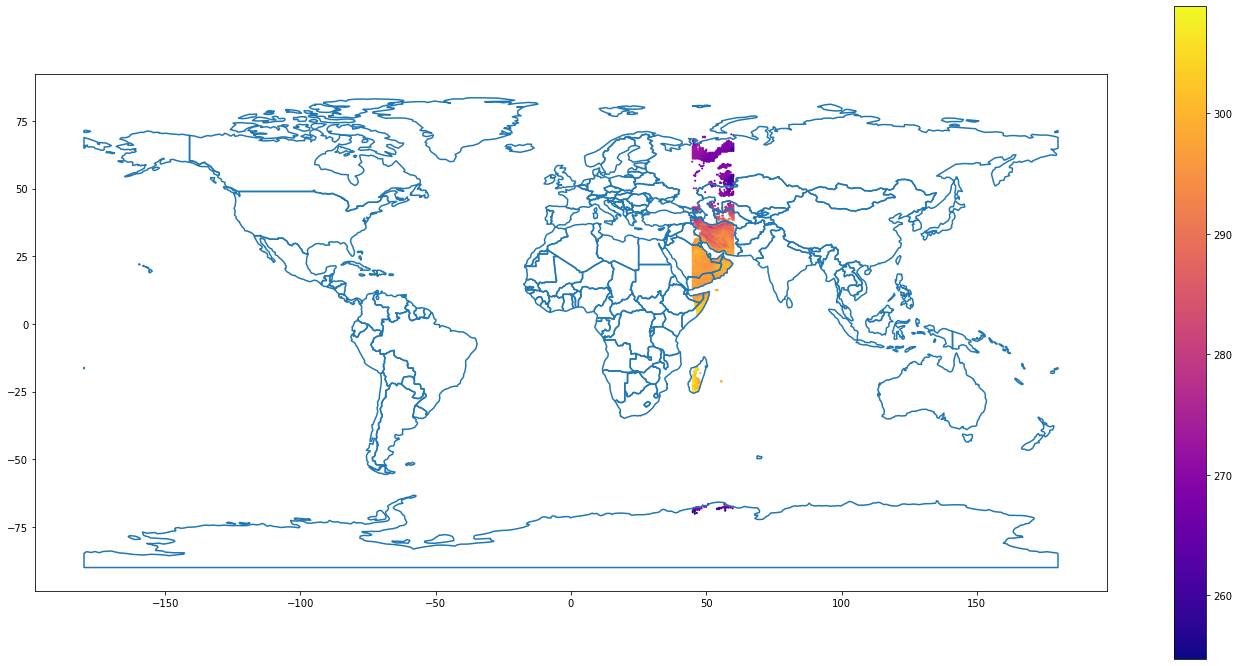

2018-01-01T11:00:00.000000000


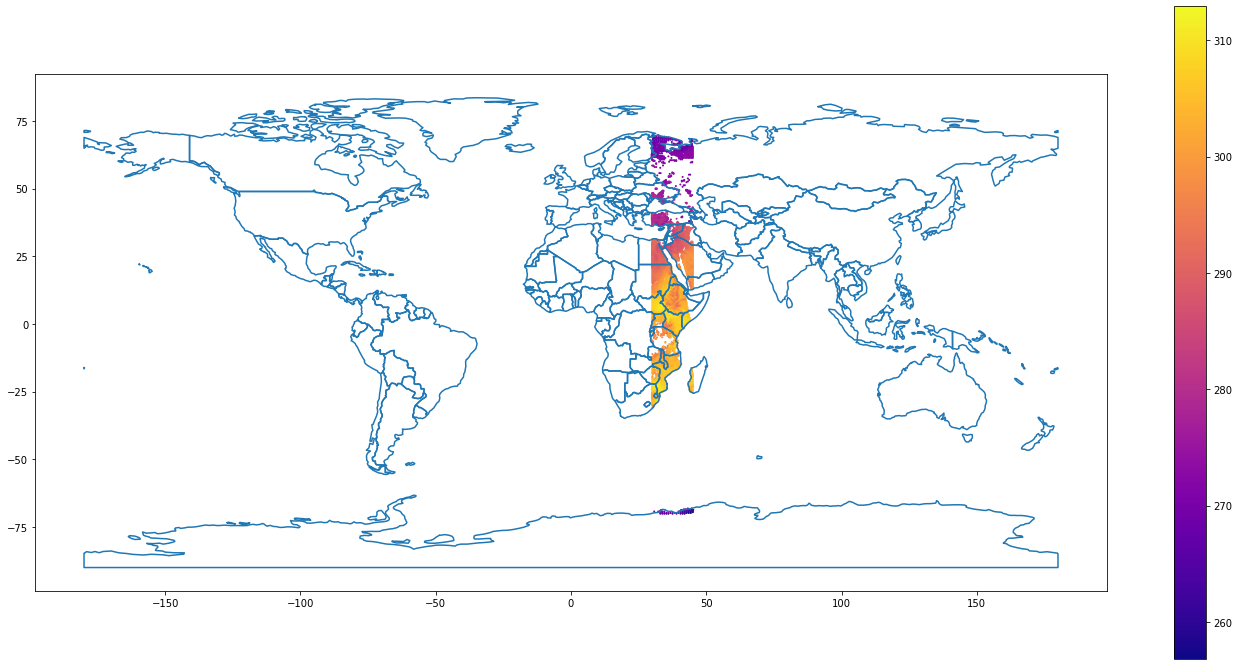

2018-01-01T12:00:00.000000000


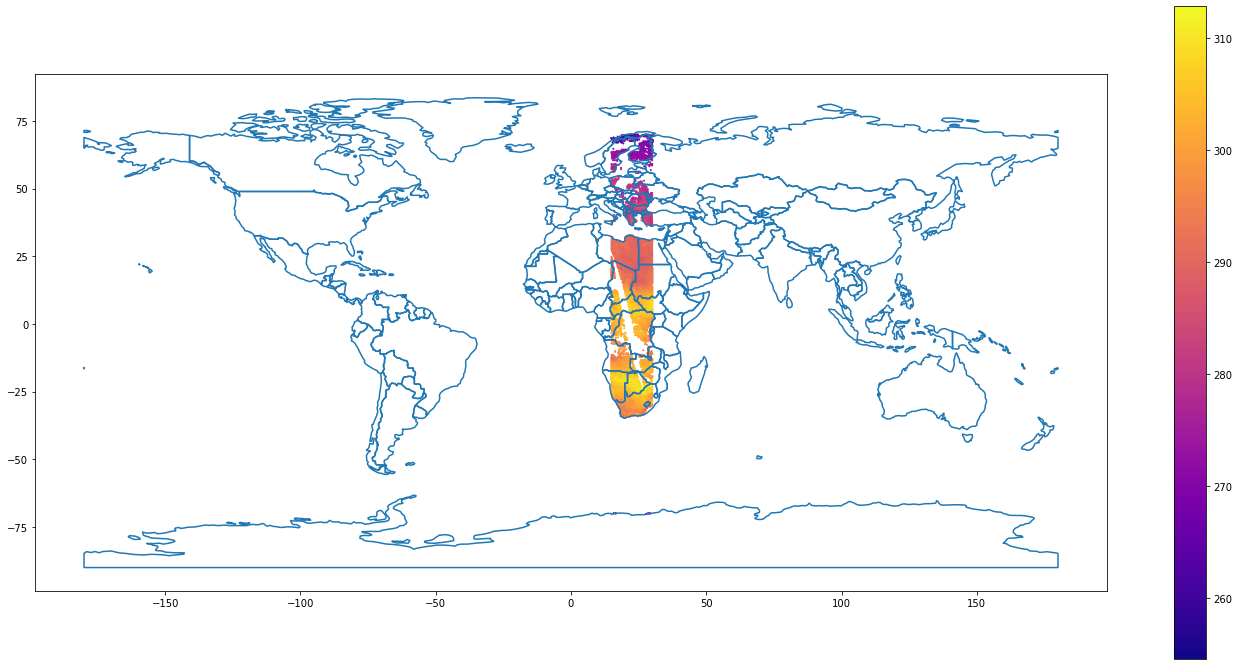

2018-01-01T13:00:00.000000000


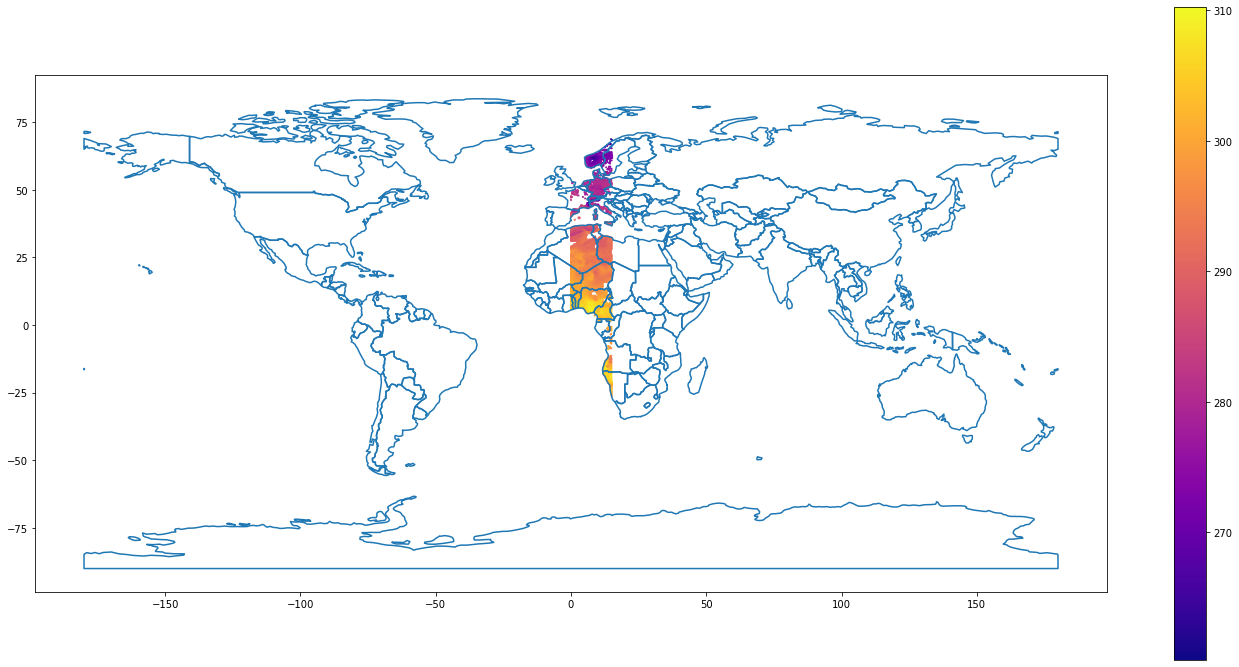

2018-01-01T14:00:00.000000000


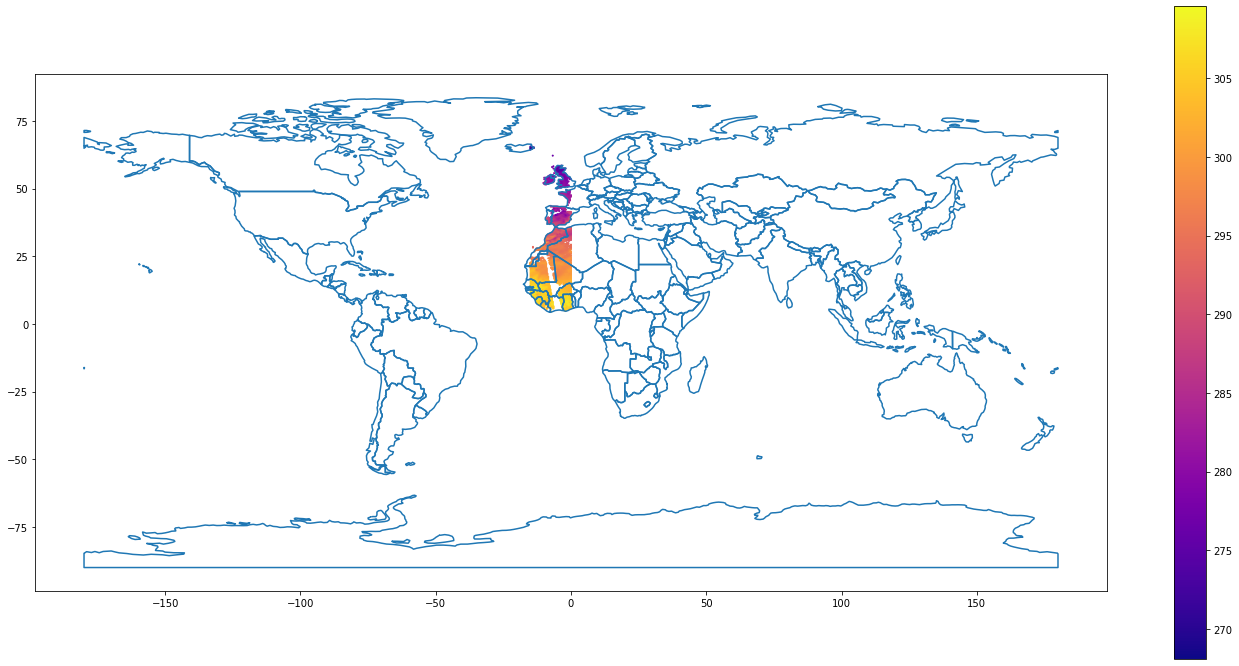

2018-01-01T15:00:00.000000000


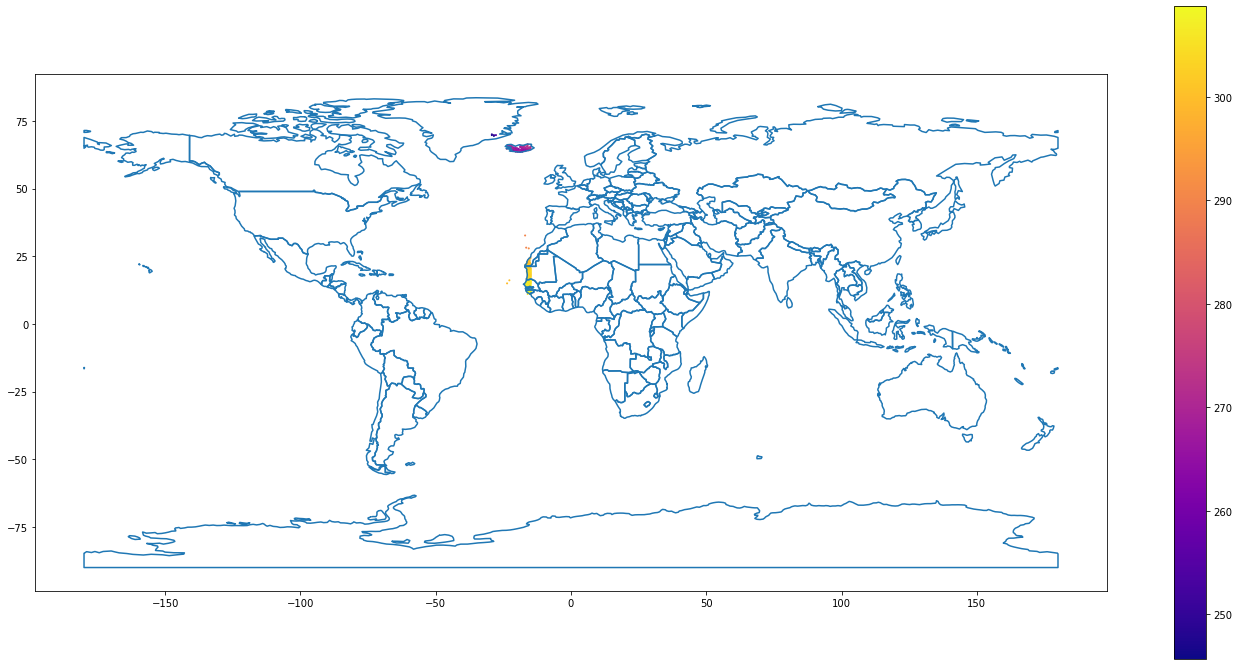

2018-01-01T16:00:00.000000000


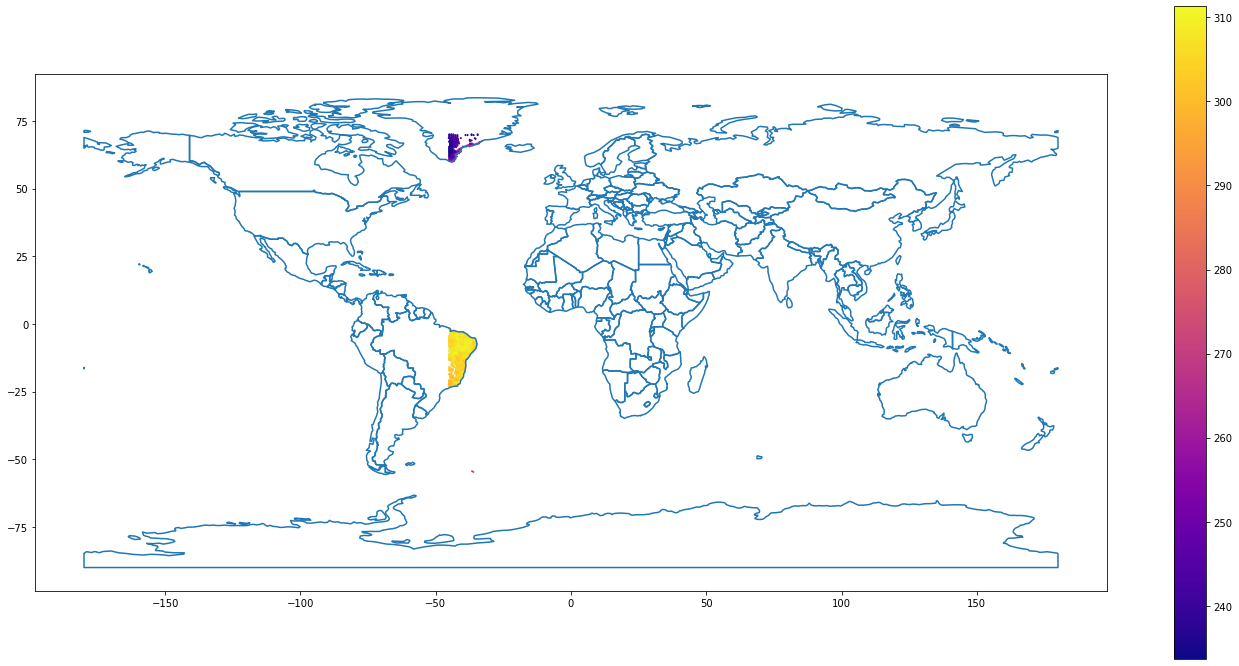

2018-01-01T17:00:00.000000000


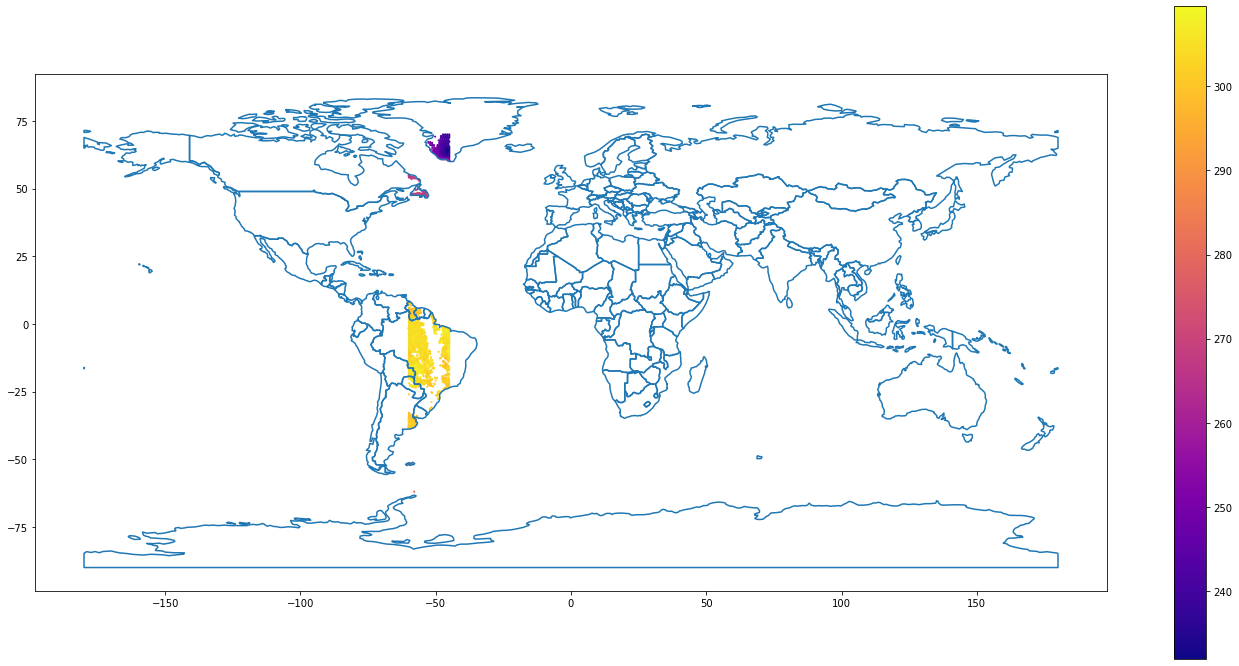

In [158]:
times = example_month.time.unique()
for t in times[8:16]: #for a selection of hours
    print(t)
    df_hour = example_month.query(f'time == "{t}"')
    plot_map(df_hour,'longitude_ERA', 'latitude_ERA', 't2m')


And we can also look at a 24 hour period of data:

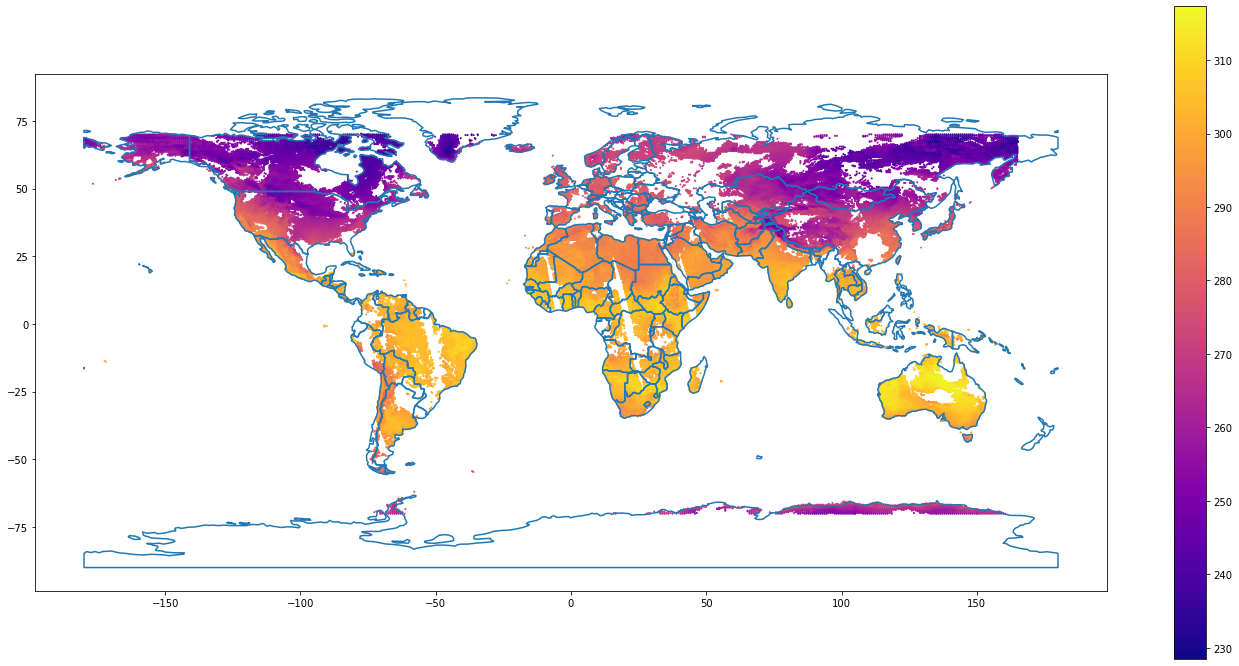

In [159]:
start_time = times[0]
end_time = times[24]
df_day = example_month.query(f'time > "{start_time}" & time < "{end_time}"')
plot_map(df_day,'longitude_ERA', 'latitude_ERA', 't2m')


Since the monthly files are not too large (~500 MB), it is useful to bring them all together into a single joined data file: `scripts/unify_monthly_matches.py`. 


This provides two files which we will use for training/testing our model: `v15/all_months.h5` , `v20/all_months.h5`

---


# 3. Training a Model <a name="trainingmodel"></a>


Given our single dataframe relating features to outputs we are now in a position to train a model.

We use 2018 as training data, 2020 as test data, holding 2019 as a validation set.

A model is trained and then makes predictions in `scripts/train_and_predict.py`

The model uses [Tensorflow](https://www.tensorflow.org/) to construct a sequential, tapered NN with 1 hidden layer. 

We output:
* Trained model, including the history 
* The model predictions, `predictions.pkl`
* Some useful meta data `meta.txt`

Two trained models using both versions (v15,v20) of the input data can be found at: 

* v15: `trained_models/ML_a15eb7cf06d942be879d487af24e1c7b`

---

# 4. Analysis and Visualisation <a name="analysis"></a>


In [89]:

import matplotlib.colors as mc
import matplotlib.colorbar as cb 
import matplotlib.pyplot as plt
import json

def plot_training_history(path,logscale):
    
    with open(path+'history.json') as f:
        d = json.load(f)

        i = 1
        training_loss = d['loss'][i:]
        epochs = np.arange(len(training_loss))
        
        

        

        fig = plt.figure(figsize=(20, 20))
        plt.plot(epochs,training_loss,label='training loss')
        try:
            validation_loss = d['val_loss'][i:]
            plt.plot(epochs,validation_loss, label='validation loss')
        except:
            pass
        plt.legend()
        
        if logscale:
            plt.yscale('log')

def load_predictions(path):

    df = pd.read_pickle(path+'predictions.pkl')

    #Create some new columns for the errors
    df['error_ERA'] = df.MODIS_LST - df.skt
    df['error_ERA_abs'] = abs(df.MODIS_LST - df.skt)

    df['error_NN'] = df.MODIS_LST - df.predictions
    df['error_NN_abs'] = abs(df.MODIS_LST - df.predictions)

    df['NN_vs_ERA'] = df['error_NN_abs'] - df['error_ERA_abs']

    #Surface some useful numbers
    print('Absolute error:')
    print('--------------------------------')
    print("NN model: Mean error, Median error, Std deviation:",df.error_NN_abs.mean(), df.error_NN_abs.median(),df.error_NN_abs.std())
    print("ERA5: Mean error, Median error, Std deviation    :", df.error_ERA_abs.mean(), df.error_ERA_abs.median(),df.error_ERA_abs.std())

    print('Biased error:')
    print('--------------------------------')
    print("NN model: Mean bias, Median bia, Std deviation:",df.error_NN.mean(), df.error_NN.median(),df.error_NN.std())
    print("ERA5: Mean bias, Median bias, Std deviation::    ", df.error_ERA.mean(), df.error_ERA.median(),df.error_ERA.std())


    return df
    
def plot_map(df,z,vmin,vmax,cmap,scale):
    
    #Get all data as vectors
    x = df.longitude_ERA
    y = df.latitude_ERA
    z1 = df[z]
    
    #Scatter plot it
    # init the figure
    fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

    if scale == 'log':
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)
        
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    sc = ax.scatter(x, y,
               s=1,
               c=cmap(norm(z1)),
               linewidths=1, alpha=.7
               )

    ax.set_title(z)
    
    plt.show()

def plot_distribution(d,bins,absolute_values):
 
   
    #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    
    
    #Plot    
    p1 = sns.histplot(data=d, x="error_ERA", ax=ax1,stat='probability', bins=bins,alpha=0.7,color='C0',label='ERA')
    p2 = sns.histplot(data=d, x="error_NN", ax=ax1,stat='probability', bins=bins,alpha=0.7,color='C1',label='NN')


    

    
    # Config
    ax1.set_xlabel('Error', fontsize = 20)
    ax1.legend().set_title(None)
    
    
    ax1.axvline(0,c='0.5', linestyle='--')
    



In [95]:
#path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_79851fcdfaa1421bb833e7e9fc8170fa/' #Original
#path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_61e4609f079c4ea0a7879b3cd1592be3/' #Original + validation
#path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_f8ea0e84bb304d2fa2a93eda74695e8c/'  #New features(v15), no validation
#path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_a76e2887bb904f5bbb9462b8ea09457e/'  #Original features, v20, no validation



df = load_predictions(path)

Absolute error:
--------------------------------
NN model: Mean error, Median error, Std deviation: 3.0593119 2.3355713 2.7397728
ERA5: Mean error, Median error, Std deviation    : 3.7471123 2.9241333 3.3045135
Biased error:
--------------------------------
NN model: Mean bias, Median bia, Std deviation: 0.11008117 0.27944946 4.1053166
ERA5: Mean bias, Median bias, Std deviation::     -0.71004343 -0.65997314 4.9453545


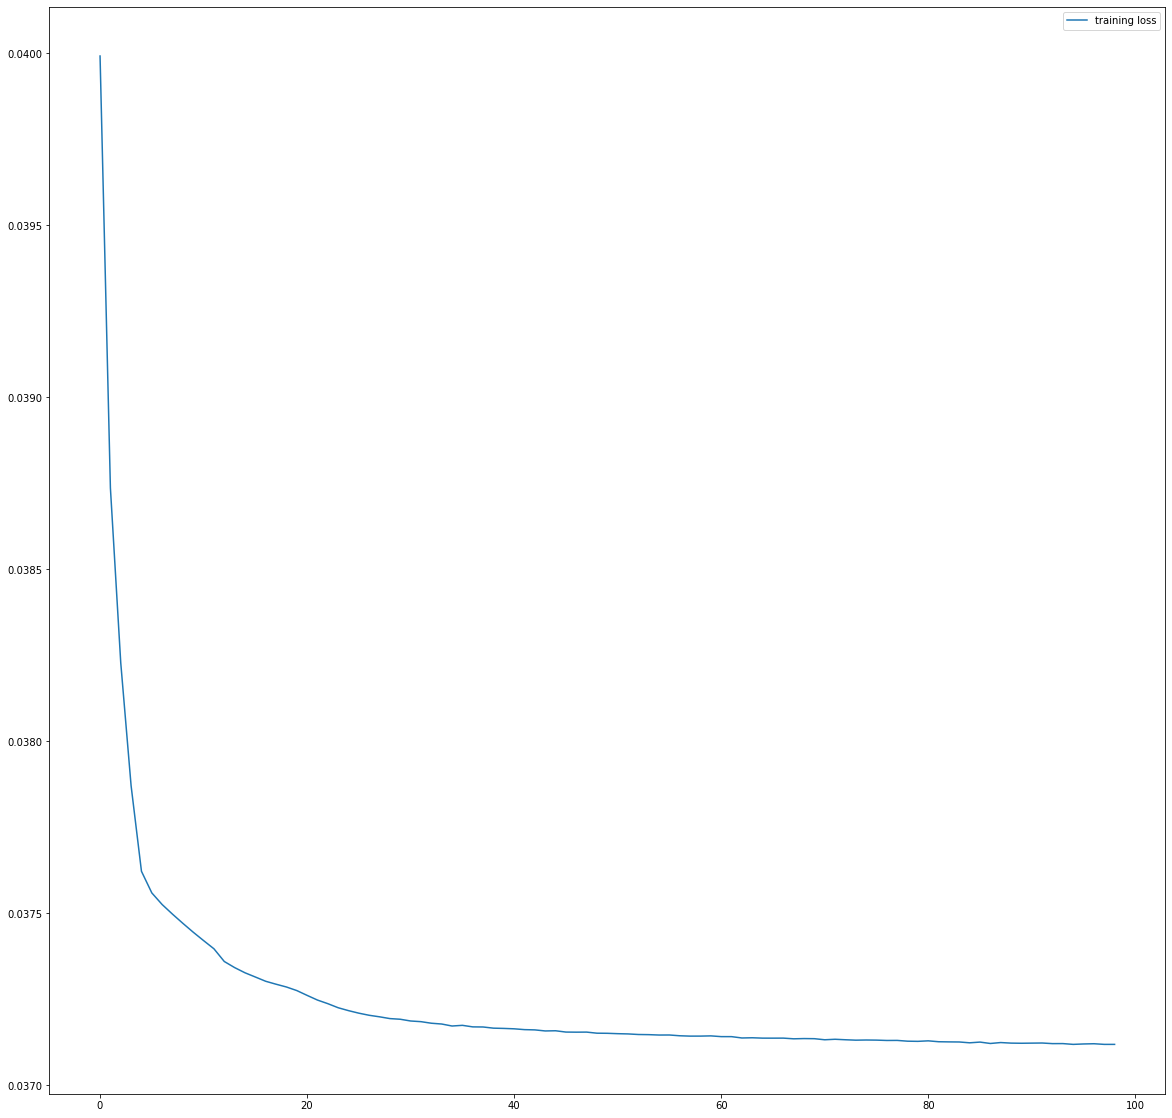

In [91]:
plot_training_history(path,logscale=False)

In [92]:
#Group by lat/long i.e. average over time
df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()


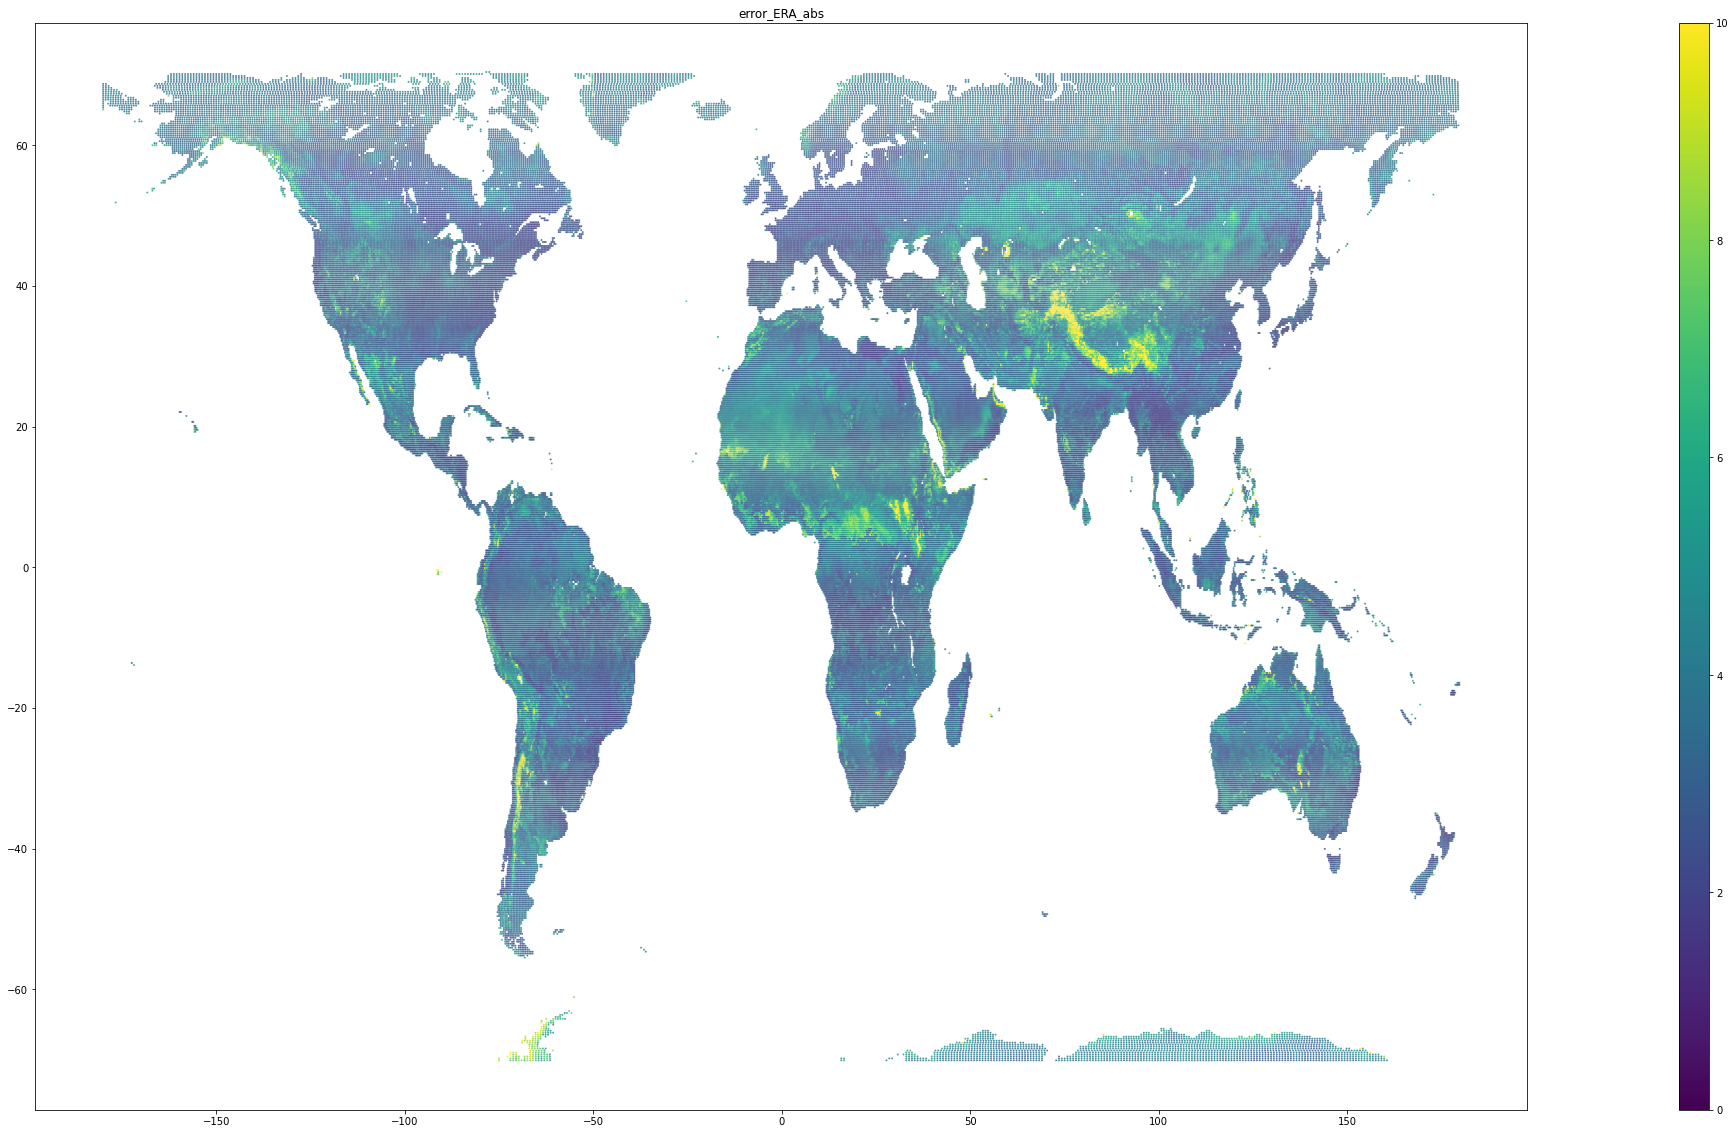

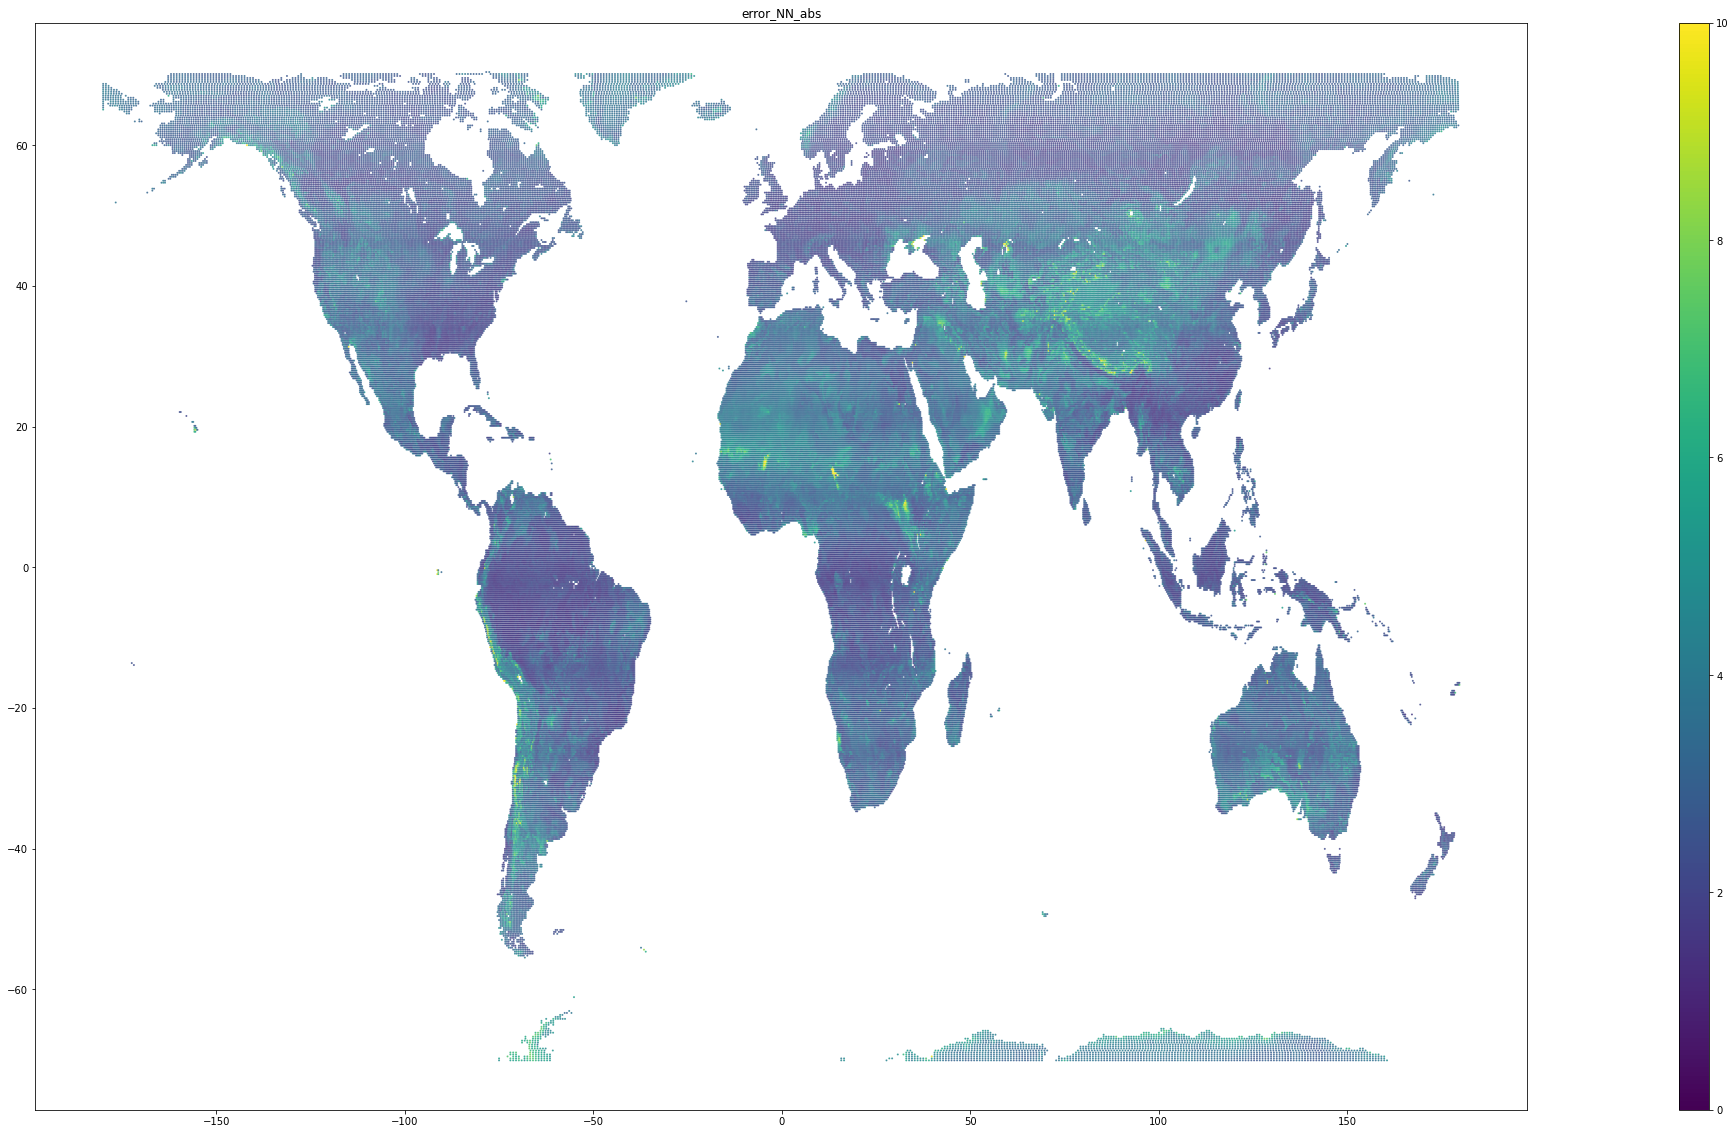

In [93]:
plot_map(df_grouped,'error_ERA_abs',vmin=0,vmax=10,cmap=plt.cm.viridis,scale=None)
plot_map(df_grouped,'error_NN_abs',vmin=0,vmax=10,cmap=plt.cm.viridis,scale=None)

# APPENDIX

In [99]:
IO_path = f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/tmp_index/'


In [254]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)





#--------------------------------#
#------Global Parameters---------#
#--------------------------------#


root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'



#Time variable ERA data
ERA_folder = root+'processed_data/ERA_timevariable/'
ERA_files = natural_sort(glob.glob(ERA_folder+'*'))
ERA_month = ERA_files[0]


index_file = f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/tmp_index/matched_index_2018-02.pkl'
df = pd.read_pickle(index_file)

v = 'v15'
constants_file = root +f'processed_data/ERA_timeconstant/ERA_constants_{v}.nc'
ds = xr.open_dataset(constants_file) #NetCDF file of features which are constant for each gridpoint


In [255]:
df

latitude_ERA  longitude_ERA   MODIS_LST                time
17305      69.836018      167.25000  236.962814 2018-01-01 02:00:00
17306      69.836018      168.00000  238.455032 2018-01-01 02:00:00
17307      69.836018      168.75000  239.666748 2018-01-01 02:00:00
17308      69.836018      169.50000  243.796036 2018-01-01 02:00:00
17309      69.836018      170.25000  243.074661 2018-01-01 02:00:00
...              ...            ...         ...                 ...
314062     -9.414517     -140.06250  303.832581 2018-01-31 23:00:00
315345     -9.695547     -139.21875  306.681488 2018-01-31 23:00:00
315346     -9.695547     -138.93750  302.595398 2018-01-31 23:00:00
316625     -9.976578     -139.21875  305.559326 2018-01-31 23:00:00
316626     -9.976578     -138.93750  308.651123 2018-01-31 23:00:00

[3037796 rows x 4 columns]

In [261]:
df_constants = ds.to_dataframe().reset_index()
df_land = df_constants.query("lsm > 0.5")

In [262]:
joined = pd.merge(df, df_land,  how='inner', left_on=['latitude_ERA','longitude_ERA'], right_on = ['latitude','longitude'],suffixes=('', '_constant'))


In [263]:
joined

latitude_ERA  longitude_ERA   MODIS_LST                time  \
0           69.836018     168.000000  238.455032 2018-01-01 02:00:00   
1           69.836018     168.000000  238.736282 2018-01-02 02:00:00   
2           69.836018     168.000000  237.587570 2018-01-03 02:00:00   
3           69.836018     168.000000  237.770493 2018-01-04 02:00:00   
4           69.836018     168.000000  238.286850 2018-01-05 02:00:00   
...               ...            ...         ...                 ...   
1167054     41.451975      24.120000  283.279968 2018-01-31 12:00:00   
1167055     22.341913      18.074074  306.620941 2018-01-31 12:00:00   
1167056     22.060883      19.851852  305.221771 2018-01-31 12:00:00   
1167057     21.498822      20.148148  299.204224 2018-01-31 12:00:00   
1167058    -20.936761      13.925926  317.521515 2018-01-31 13:00:00   

        time_constant  values  slt       sdfor  number   step  ...  \
0          2018-01-01   17306  2.0    4.505615       0 0 days  ...   
1          2018-01-01   17306  2.0    4.505615       0 0 days  ...   
2          2018-01-01   17306  2.0    4.505615       0 0 days  ...   
3          2018-01-01   17306  2.0    4.505615       0 0 days  ...   
4          2018-01-01   17306  2.0    4.505615       0 0 days  ...   
...               ...     ...  ...         ...     ...    ...  ...   
1167054    2018-01-01   92900  3.0  172.232849       0 0 days  ...   
1167055    2018-01-01  169091  3.0   47.302368       0 0 days  ...   
1167056    2018-01-01  170312  2.0   21.033142       0 0 days  ...   
1167057    2018-01-01  172743  2.0    5.235229       0 0 days  ...   
1167058    2018-01-01  365807  1.0   38.881409       0 0 days  ...   

                   z      isor        sdor       cvl        cl      anor  \
0         104.242065  0.720063    6.793701  0.626860  0.000000  0.814416   
1         104.242065  0.720063    6.793701  0.626860  0.000000  0.814416   
2         104.242065  0.720063    6.793701  0.626860  0.000000  0.814416   
3         104.242065  0.720063    6.793701  0.626860  0.000000  0.814416   
4         104.242065  0.720063    6.793701  0.626860  0.000000  0.814416   
...              ...       ...         ...       ...       ...       ...   
1167054  9131.996094  0.497342  263.757690  0.112167  0.004099  1.105965   
1167055  7990.031250  0.478046   59.284546  0.000934  0.000000 -0.675741   
1167056  6493.269531  0.337366   32.600098  0.007499  0.000000 -0.321470   
1167057  6253.199219  0.343714    8.771851  0.000041  0.000000 -0.482581   
1167058  2754.320312  0.324881   46.010010  0.002831  0.000000 -0.991000   

             slor      sr   tvh   tvl  
0        0.001238  0.0001   0.0   9.0  
1        0.001238  0.0001   0.0   9.0  
2        0.001238  0.0001   0.0   9.0  
3        0.001238  0.0001   0.0   9.0  
4        0.001238  0.0001   0.0   9.0  
...           ...     ...   ...   ...  
1167054  0.047508  0.0001  19.0   1.0  
1167055  0.010277  0.0001   0.0   0.0  
1167056  0.005352  0.0001   0.0  11.0  
1167057  0.001390  0.0001   0.0   0.0  
1167058  0.009299  0.0001   0.0   0.0  

[1167059 rows x 27 columns]

In [264]:
ERA = xr.open_dataset(ERA_month,engine='cfgrib',backend_kwargs={'indexpath': ''})


In [266]:
ERA= ERA.assign_coords({"longitude": (((ERA.longitude + 180) % 360) - 180)})


In [ ]:
#Now filter to get land values only 
latitude_filter = (ERA.latitude.isin(joined.latitude_ERA))
ERA_lat_filtered = ERA.where(latitude_filter, drop=True)
  #  ERA_hour = ERA_hour.where(land_filter,drop=True)

In [139]:
selection_index = 10 #Use if you dont want to run for all the ERA files e.g. script gets killed after X months
selected_ERA_files = ERA_files[selection_index:] 
print(selected_ERA_files) 

['/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_10.grib', '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_11.grib', '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_12.grib', '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_13.grib', '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_14.grib', '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_15.grib', '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_16.grib', '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_17.grib', '/network/group/aopp/predict/TIP016_PAXTON_RPSP

---

In [233]:
ERA_files[0]

'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_0.grib'

In [235]:
#Load a month of ERA data
ERA_month = xr.open_dataset(ERA_files[0],engine='cfgrib',backend_kwargs={'indexpath': ''})

In [236]:
%%time
ERA_df = ERA_month.to_dataframe()

CPU times: user 2min 43s, sys: 14min 15s, total: 16min 58s
Wall time: 20min 39s


In [9]:
import os
import time
import json
import pandas as pd
import xarray as xr
import uuid




    
    
### --- Define all functions
def train_test_split(df,
                     train_condition,test_condition,
                     normalised_features,normalised_targets,
                     output_columns):
    
   
    #Separate into train/test based on time
    idx_train = df.time < train_condition 
    idx_valid = (train_condition <= df.time) & (df.time <= test_condition) 
    idx_test = df.time > test_condition 
    
    print ('idx valid = ', idx_valid.sum())
    
    split_data = {'x_train': normalised_features[idx_train],
                  'y_train': normalised_targets[idx_train],
                  'x_valid': normalised_features[idx_valid], 
                  'y_valid': normalised_targets[idx_valid],
                  'x_test' : normalised_features[idx_test],
                  'y_test' : normalised_targets[idx_test]
                 }
    
    # Create a "results_df" copy that will be used later for smaller IO. Won't output all features
    results_df = df[output_columns].copy()
    results_df = results_df[idx_test] #For IO we will just output predictions
    
    
    return split_data,results_df
    

            
            


#--------------------------------#
#----------Parameters------------#
#--------------------------------#
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'

#Inputs
version = 'v15' #v20
input_file = f'{root}processed_data/joined_data/{version}/all_months.h5'


#Outputs
output_path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/'
output_cols = ['latitude_ERA', 'longitude_ERA','time','skt','MODIS_LST'] #we don't output all columns in our results

#Train/Test split. Everything not in these two groups is validation data.
train_condition = pd.to_datetime("2019-01-01 00:00:00") #Everything less than this is used for training data
test_condition  = pd.to_datetime("2020-01-01 00:00:00") #Everything greater than this is used for test data. 
feature_names = ['sp', 'msl', 'u10', 'v10', 't2m',
            'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m','fal', 
            'skt', 
            'lsm',  'slt', 'sdfor','lsrh', 'cvh',  'z', 'isor', 'sdor', 'cvl','cl','anor', 'slor', 'sr', 'tvh', 'tvl']

target_var = ['MODIS_LST'] 


#Model parameters
epochs = 1
batch_size = 100000
use_validation_data = True #Do you want to use validation data for early stopping? Stopping conditions are defined in train_NN()
optimizer = 'adam'

                 
            

#--------------------------------#
#--------------MAIN--------------#
#--------------------------------#

#Get the matched data
print ('Reading data')
df= pd.read_hdf(input_file)
    
#Normalise everything
print('Normalizing')
features = df[feature_names]
target = df[target_var]
    
features_normed = (features-features.mean())/features.std()
target_normed = (target-target.mean())/target.std()


#Split data into training and testing set
print('Split data')
split_data,results_df = train_test_split(df,train_condition,test_condition,
                                                            features_normed,target_normed,
                                                            output_cols)

# #Train model
# print('Train')
# history,model = train_NN(split_data['x_train'],split_data['y_train'],
#                          split_data['x_valid'],split_data['y_valid'],
#                          epochs,batch_size,use_validation_data,optimizer)


split_data['x_test']


#Make some predictions
print('Predict')
#predictions_normalized = model.predict()
# predictions = (predictions_normalized * target.std() ) + target.mean() #un-normalsie to get 'physical' value



# predictions_normalized = model.predict(x_test)
# print(predictions_normalized.shape)

# #Bring together the test data and predictions into a single pandas df
# results_df['predictions'] = predictions



# #Save everything to disk
# parameters_dict = {'input_file':     input_file,
#                   'train_condition': train_condition,
#                   'test_condition':  test_condition,
#                   'epochs':          epochs,
#                   'batch_size':      batch_size}
                                   


# write_outputs(output_path+ID,model,history,results_df,parameters_dict)

    


# print ("All completed OK")


Reading data
Normalizing
Split data
idx valid =  35742895
Predict


In [13]:
(target_normed * target.std() ) + target.mean()

MODIS_LST
0    289.155457
1    289.445984
2    299.311340
3    299.750610
4    297.837585
..          ...
857  241.880630
858  243.993393
859  246.165604
860  247.287582
861  249.566437

[106017919 rows x 1 columns]

In [20]:
preds = np.zeros((10,1))

print (preds.shape)

(10, 1)


In [47]:
T_normalize_mean = target.mean().values[0]
T_normalize_std = target.std() 

In [49]:
type(T_normalize_mean)

numpy.float32

In [45]:
T_normalize_std = T_normalize_std.values[0]
T_normalize_mean = T_normalize_mean.values[0]

In [46]:
type(T_normalize_std)

numpy.float32

In [41]:
predictions = (preds * T_normalize_std ) + T_normalize_mean


In [25]:
std = target.std()
av = target.mean()

In [26]:
predsN = (preds * std ) + av


ValueError: Length of values (10) does not match length of index (1)

In [27]:
example = np.array([1, 2, 3]) * 2